<h3 align="right">STR, &nbsp; dSPN, &nbsp; (e) 150917_c10_D1, &nbsp; (m) WT-P270-20 <br> </h3>

# Model selection

## Model data

In [60]:
import json
import efel
import numpy as np
import bluepyopt as bpopt
import bluepyopt.ephys as ephys
import cell_model, cell_evaluator
morphofile = 'morphology/WT-P270-20-15ak-cor.swc'
parameters = cell_model.define_parameters('parameters.json')
mechanisms = cell_model.define_mechanisms('mechanisms.json')
protocol_definitions  = json.load(open('config/protocols-val.json'))

## Simulation environment

In [61]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [62]:
from utils import *

In [63]:
!rm -rf x86_64
!nrnivmodl mechanisms

Creating x86_64 directory for .o files.

/home/HDD-drive/Repos/Neuron/Alex_SPN_models
mechanisms/bk.mod mechanisms/cadyn.mod mechanisms/cal12.mod mechanisms/cal13.mod mechanisms/caldyn.mod mechanisms/can.mod mechanisms/car.mod mechanisms/cav32.mod mechanisms/cav33.mod mechanisms/kaf.mod mechanisms/kas.mod mechanisms/kir.mod mechanisms/naf.mod mechanisms/sk.mod mechanisms/tmglut.mod
bk.mod cadyn.mod cal12.mod cal13.mod caldyn.mod can.mod car.mod cav32.mod cav33.mod kaf.mod kas.mod kir.mod naf.mod sk.mod tmglut.mod
"/home/HDD-drive/neuron/nrn/x86_64/bin/nocmodl" bk
Translating bk.mod into bk.c
Thread Safe
"/home/HDD-drive/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/HDD-drive/neuron/nrn/include/nrn" -I"/home/HDD-drive/neuron/nrn/x86_64/lib"      -g -O2 -c -o bk.lo bk.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/HDD-drive/neuron/nrn/include/nrn -I/home/HDD-drive/neuron/nrn/x86_64/lib -g -O2 -c bk.c  -fPIC -DPIC -o .libs/bk.o

"/home/HDD-drive/neuron/nrn/share/nrn/libtool" --tag=CC --mode=link mpicc -module  -g -O2    -o libnrnmech.la -rpath "/home/HDD-drive/neuron/nrn/x86_64/lib"  bk.lo cadyn.lo cal12.lo cal13.lo caldyn.lo can.lo car.lo cav32.lo cav33.lo kaf.lo kas.lo kir.lo naf.lo sk.lo tmglut.lo mod_func.lo  -L"/home/HDD-drive/neuron/nrn/x86_64/lib" -lnrnoc -loc -lmemacs -lnrnmpi -lscopmath -lsparse13 -lreadline -lncurses -L"/home/HDD-drive/neuron/nrn/x86_64/lib" "/home/HDD-drive/neuron/nrn/x86_64/lib/libnrniv.la" -livoc -lneuron_gnu -lmeschach -lsundials       -lm -ldl
libtool: link: mpicc -shared  -fPIC -DPIC  .libs/bk.o .libs/cadyn.o .libs/cal12.o .libs/cal13.o .libs/caldyn.o .libs/can.o .libs/car.o .libs/cav32.o .libs/cav33.o .libs/kaf.o .libs/kas.o .libs/kir.o .libs/naf.o .libs/sk.o .libs/tmglut.o .libs/mod_func.o   -Wl,-rpath -Wl,/home/HDD-drive/neuron/nrn/x86_64/lib -Wl,-rpath -Wl,/home/HDD-drive/neuron/nrn/x86_64/lib -L/home/HDD-drive/neuron/nrn/x86_64/lib /home/HDD-drive/neuron/nrn/x86_64/lib/lib

## Cell model definition

In [64]:
morphology = ephys.morphologies.NrnFileMorphology(
    morphofile, do_replace_axon=True)

In [79]:
### the below code is (slighlty updated) from the BluePyOpt/examples/expsyn/ExpSyn.ipynb notebook:
# https://github.com/BlueBrain/BluePyOpt/blob/master/examples/expsyn/ExpSyn.ipynb

# NEURON simulator
nrn_sim = ephys.simulators.NrnSimulator()

# Object that points to sectionlist somatic
somatic_loc = ephys.locations.NrnSeclistLocation('somatic',seclist_name='somatic')

# Object that points to the center of the soma
somacenter_loc = ephys.locations.NrnSeclistCompLocation(
    name='somacenter',
    seclist_name='somatic',
    sec_index=0,
    comp_x=0.5)


# Add ExpSyn synapse pointprocess at the center of the soma
expsyn_mech = ephys.mechanisms.NrnMODPointProcessMechanism(                     
    name='tmglut',                                                              
    suffix='tmGlut',                                                            
    locations=[somacenter_loc])

# Once we have defined a point process, we can create a Location object that points to it
expsyn_loc = ephys.locations.NrnPointProcessLocation(                           
    'expsyn_loc',                                                               
    pprocess_mech=expsyn_mech)

tau_param = ephys.parameters.NrnPointProcessParameter(                   
    name='tmglut_tau',                                                          
    param_name='tau',                                                           
    value=3,                                                                    
    bounds=[0, 50],                                                             
    locations=[expsyn_loc])
tauR_param = ephys.parameters.NrnPointProcessParameter(                   
    name='tmglut_tauR',                                                          
    param_name='tauR',                                                           
    value=400,                                                                    
    bounds=[300,1000],                                                             
    locations=[expsyn_loc])
tauF_param = ephys.parameters.NrnPointProcessParameter(                   
    name='tmglut_tauF',                                                          
    param_name='tauF',                                                           
    value=200,                                                                    
    bounds=[100,300],                                                             
    locations=[expsyn_loc])

parameters.append(tau_param)
parameters.append(tauR_param)
parameters.append(tauF_param)
#expsyn_mech.tauR = 200
#expsyn_mech.tauF = 30
#expsyn_mech.tau  = 3
#expsyn_mech.use_stp  = 0



In [80]:
cell = ephys.models.CellModel(
    'dspn', 
    morph=morphology, 
    mechs=mechanisms+[expsyn_mech], 
    params=parameters)
#print cell

In [81]:
# Now we need to define the fitness function. 
# (The idea is to stimulate the synapse 5 times, and let the resulting train of EPSPs reach exactly -50 mV) 
# no optimization used.

#We first create a stimulus that injects the presynaptic events:
stim_start = 200
number     = 10
interval   = 1000.0/50    # Hz -> ISI (ms)

netstim = ephys.stimuli.NrnNetStimStimulus(                                  
    total_duration=600,                                                      
    number=number,                                                                
    interval=interval,                                                              
    start=stim_start,                                                        
    weight=1e-2,                                                             
    locations=[expsyn_loc])

stim_end = stim_start*2 + interval*number

rec = ephys.recordings.CompRecording(
    name='soma.v', 
    location=somacenter_loc,
    variable='v')

# set constant istim
protocol_definition = protocol_definitions.items()[0] # select first prot (same in all)
stimuli = [] 
stimulus_definition = protocol_definition[1]['stimuli'][1]
stimuli.append(ephys.stimuli.NrnSquarePulse(
    step_amplitude=stimulus_definition['amp'],
    step_delay=stimulus_definition['delay'],
    step_duration=stimulus_definition['duration'],
    location=somacenter_loc,
    total_duration=600))

# append netstim
stimuli.append(netstim)

protocol = ephys.protocols.SweepProtocol(
    'netstim_protocol',
    stimuli,
    [rec])

In [82]:
opt_params = [p.name for p in cell.params.values() if not p.frozen]
#for x in sorted(opt_params): print x

features = []
weights = []
for i in range(number):
    max_volt_feature = ephys.efeatures.eFELFeature(                              
        'maximum_voltage_%d' % (i),                                                       
        efel_feature_name='maximum_voltage',                                     
        recording_names={'': 'soma.v'},                                          
        stim_start=stim_start+i*interval,                                                   
        stim_end=stim_start+(i+1)*interval,                                                       
        exp_mean=-82.5 + 3/ (1 + np.exp((i-3)/-2.0)),                                                            
        exp_std=1.0)       

    features.append(max_volt_feature)
    weights.append(1.0)

max_volt_objective = ephys.objectives.WeightedSumObjective(                    
    max_volt_feature.name,                                                   
    features,
    weights)

score_calc = ephys.objectivescalculators.ObjectivesCalculator(               
    [max_volt_objective]) 
    
evaluator = ephys.evaluators.CellEvaluator(
    cell_model=cell,
    param_names=opt_params,
    fitness_protocols={protocol.name: protocol},
    fitness_calculator=score_calc,
    sim=nrn_sim)

In [83]:
best_models = json.load(open('best_models.json'))
default_param_values = best_models[3]
default_param_values['tmglut_tau'] = 30
default_param_values['tmglut_tauR'] = 800
default_param_values['tmglut_tauF'] = 100
evaluator.evaluate_with_dicts(default_param_values)

{'maximum_voltage_9': 37.77988263398147}

## skipping optimization part

In [70]:
'''optimisation = bpopt.optimisations.DEAPOptimisation(                         
    evaluator=cell_evaluator,                                                
    offspring_size=10)                                                       

_, hall_of_fame, _, _ = optimisation.run(max_ngen=5)'''

'optimisation = bpopt.optimisations.DEAPOptimisation(                         \n    evaluator=cell_evaluator,                                                \n    offspring_size=10)                                                       \n\n_, hall_of_fame, _, _ = optimisation.run(max_ngen=5)'

<IPython.core.display.Javascript object>


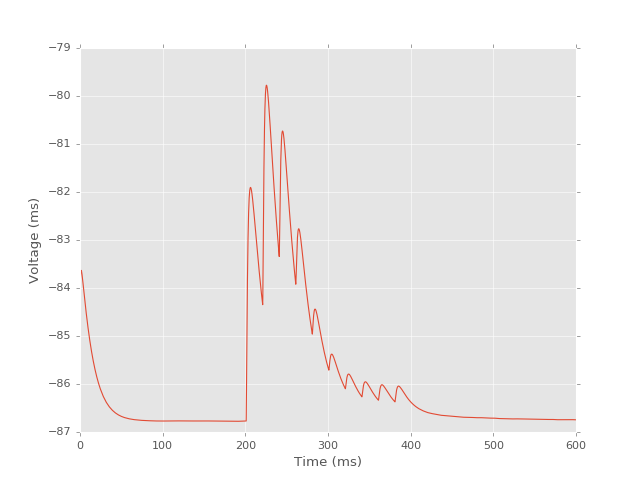

In [84]:
#best_ind_dict = best_models[3]                        
responses = protocol.run(                                                    
    cell_model=cell,                                                         
    param_values=default_param_values,                                              
    sim=nrn_sim)                                                             

time = responses['soma.v']['time']                                           
voltage = responses['soma.v']['voltage']                                     
                                              
plt.style.use('ggplot')                                                      
plt.plot(time, voltage)                                                      
plt.xlabel('Time (ms)')                                                      
plt.ylabel('Voltage (ms)')                                                   
plt.show()

## extract features

In [72]:
'''from scipy.signal import argrelextrema
trace = np.array(list(voltage))
m = argrelextrema(trace, np.greater)
plt.figure()
for p in m[0]:
    if time[p] >= 200 and time[p] <= 400:
        print p, trace[p]
        plt.plot(time[p],trace[p], '*', ms=10, c='k')
plt.plot(time,trace)
plt.show()'''

"from scipy.signal import argrelextrema\ntrace = np.array(list(voltage))\nm = argrelextrema(trace, np.greater)\nplt.figure()\nfor p in m[0]:\n    if time[p] >= 200 and time[p] <= 400:\n        print p, trace[p]\n        plt.plot(time[p],trace[p], '*', ms=10, c='k')\nplt.plot(time,trace)\nplt.show()"

In [73]:
'''from scipy import signal
max_peakind = signal.find_peaks_cwt(voltage, np.arange(1,10))
max_peakind
plt.figure()
for p in max_peakind:
    if time[p] >= 200 and time[p] <= 400:
        print p, trace[p]
        plt.plot(time[p],trace[p], '*', ms=10, c='k')
plt.plot(time,trace)
plt.show()'''

"from scipy import signal\nmax_peakind = signal.find_peaks_cwt(voltage, np.arange(1,10))\nmax_peakind\nplt.figure()\nfor p in max_peakind:\n    if time[p] >= 200 and time[p] <= 400:\n        print p, trace[p]\n        plt.plot(time[p],trace[p], '*', ms=10, c='k')\nplt.plot(time,trace)\nplt.show()"

In [74]:
'''
c = (np.diff(np.sign(np.diff(voltage))) < 0).nonzero()[0] +1
plt.figure()
for p in c:
    if time[p] >= 200 and time[p] <= 400:
        print p, trace[p]
        plt.plot(time[p],trace[p], '*', ms=10, c='k')
plt.plot(time,trace)
plt.show()
c'''

"\nc = (np.diff(np.sign(np.diff(voltage))) < 0).nonzero()[0] +1\nplt.figure()\nfor p in c:\n    if time[p] >= 200 and time[p] <= 400:\n        print p, trace[p]\n        plt.plot(time[p],trace[p], '*', ms=10, c='k')\nplt.plot(time,trace)\nplt.show()\nc"

In [75]:
features = efel.getFeatureNames()
features

['AHP1_depth_from_peak',
 'AHP2_depth_from_peak',
 'AHP_depth',
 'AHP_depth_abs',
 'AHP_depth_abs_slow',
 'AHP_depth_diff',
 'AHP_depth_from_peak',
 'AHP_slow_time',
 'AHP_time_from_peak',
 'AP1_amp',
 'AP1_begin_voltage',
 'AP1_begin_width',
 'AP1_peak',
 'AP1_width',
 'AP2_AP1_begin_width_diff',
 'AP2_AP1_diff',
 'AP2_AP1_peak_diff',
 'AP2_amp',
 'AP2_begin_voltage',
 'AP2_begin_width',
 'AP2_peak',
 'AP2_width',
 'AP_amplitude',
 'AP_amplitude_change',
 'AP_amplitude_diff',
 'AP_amplitude_from_voltagebase',
 'AP_begin_indices',
 'AP_begin_time',
 'AP_begin_voltage',
 'AP_begin_width',
 'AP_duration',
 'AP_duration_change',
 'AP_duration_half_width',
 'AP_duration_half_width_change',
 'AP_end_indices',
 'AP_fall_indices',
 'AP_fall_rate',
 'AP_fall_rate_change',
 'AP_fall_time',
 'AP_height',
 'AP_phaseslope',
 'AP_phaseslope_AIS',
 'AP_rise_indices',
 'AP_rise_rate',
 'AP_rise_rate_change',
 'AP_rise_time',
 'AP_width',
 'APlast_amp',
 'APlast_width',
 'BAC_maximum_voltage',
 'BAC_w

In [76]:
trace1 = {}
trace1['T'] = time
trace1['V'] = voltage
trace1['stim_start'] = [stim_start]
trace1['stim_end'] = [400]
traces = [trace1]

#efel.getFeatureValues(traces, features)